In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [3]:
import numpy as np
import pandas as pd

# Set the seed for Keras
np.random.seed(4)

from data.data import get_data
from features.features import add_features

# auxiliary
from data.data import load_nest_counts
from utils.NestDistance import NestDistance

from model.model import get_model, split_train_test

from model.predictions import fit_model, predict, assemble_submission, convert_predictions, AMAPE

from utils.visualisations import PenguinVisualisation

Using Theano backend.


In [4]:
# Define the properties of this run
ts_steps = 4
radius = 50

In [5]:
# Get the data with a given time lag
df_features, scaler = get_data(ts_steps)
df_features.head()

y_true inferred_y_true  t0   t1   t2   t3  \
site_id species           year                                              
ACUN    adelie penguin    1983  1.0000            True NaN  1.0  1.0  1.0   
        chinstrap penguin 1983  1.0000            True NaN  1.0  1.0  1.0   
ADAM    adelie penguin    1983  1.0000            True NaN  1.0  1.0  1.0   
ADAR    adelie penguin    1983  1.0331            True NaN  1.0  1.0  1.0   
AILS    chinstrap penguin 1983  1.0000            True NaN  1.0  1.0  1.0   

                                countError  
site_id species           year              
ACUN    adelie penguin    1983         0.5  
        chinstrap penguin 1983         0.5  
ADAM    adelie penguin    1983         0.5  
ADAR    adelie penguin    1983         0.1  
AILS    chinstrap penguin 1983         0.5

In [6]:
# Remove the first occurence (and potentially entries with missing values)
df_features.dropna(inplace=True)

In [7]:
# Add the features to the DataFrame
df_features = add_features(df_features, radius=radius)
df_features.head()

y_true inferred_y_true   t0   t1   t2   t3  \
site_id species        year                                               
ACUN    adelie penguin 1984     1.0            True  1.0  1.0  1.0  1.0   
                       1985     1.0            True  1.0  1.0  1.0  1.0   
                       1986     1.0            True  1.0  1.0  1.0  1.0   
                       1987     1.0            True  1.0  1.0  1.0  1.0   
                       1988     1.0            True  1.0  1.0  1.0  1.0   

                             countError  proximityNestCountChange  siteCount  
site_id species        year                                                   
ACUN    adelie penguin 1984         0.5                  0.981254          8  
                       1985         0.5                  0.980524          8  
                       1986         0.5                  0.979735          8  
                       1987         0.5                  0.978878          8  
                       1988         0.5                  0.977947          8

In [8]:
# Get the model
model = get_model(ts_steps)

In [9]:
# Split into train and test
df_train, _ = split_train_test(df_features)

In [10]:
# Run the fitting
model = fit_model(df_train, model, epochs=20)

Epoch 1/20
17496/17496 [==============================] - 0s - loss: 1.0014     
Epoch 2/20
17496/17496 [==============================] - 0s - loss: 0.6130     
Epoch 3/20
17496/17496 [==============================] - 0s - loss: 0.4814     

In [11]:
# Predict the steps ahead (note that I need to predict here 5 steps as the last step can't be used for training)
df_predictions = predict(df_features, 5, model, radius)
df_predictions.head()

y_true  inferred_y_true   t0   t1   t2   t3  \
site_id species        year                                                
ACUN    adelie penguin 1984     1.0              1.0  1.0  1.0  1.0  1.0   
                       1985     1.0              1.0  1.0  1.0  1.0  1.0   
                       1986     1.0              1.0  1.0  1.0  1.0  1.0   
                       1987     1.0              1.0  1.0  1.0  1.0  1.0   
                       1988     1.0              1.0  1.0  1.0  1.0  1.0   

                             countError  proximityNestCountChange  siteCount  \
site_id species        year                                                    
ACUN    adelie penguin 1984         0.5                  0.981254          8   
                       1985         0.5                  0.980524          8   
                       1986         0.5                  0.979735          8   
                       1987         0.5                  0.978878          8   
                       1988         0.5                  0.977947          8   

                               y_pred  
site_id species        year            
ACUN    adelie penguin 1984  0.994698  
                       1985  0.994597  
                       1986  0.994487  
                       1987  0.994368  
                       1988  0.994239

In [12]:
# Rescale the predictions
df_predictions = convert_predictions(df_predictions, scaler)
df_predictions.head()

year                                1984           1985           1986  \
site_id species                                                          
ACUN    adelie penguin       1997.354039    1997.150453    1996.930230   
        chinstrap penguin    4059.659958    4059.659481    4059.659481   
ADAM    adelie penguin         76.485946      76.485946      76.485946   
ADAR    adelie penguin     266116.655118  269137.340988  274734.303942   
AILS    chinstrap penguin    6089.489937    6089.489937    6089.489937   

year                                1987           1988           1989  \
site_id species                                                          
ACUN    adelie penguin       1996.690978    1996.431259    1996.147124   
        chinstrap penguin    4059.659958    4059.659958    4059.659958   
ADAM    adelie penguin         76.485946      76.485946      76.485946   
ADAR    adelie penguin     282181.371048  276843.485560  262285.485667   
AILS    chinstrap penguin    6089.489937    6089.489937    6089.489937   

year                                1990           1991           1992  \
site_id species                                                          
ACUN    adelie penguin       1995.835461    1995.492201    1995.112318   
        chinstrap penguin    4059.659958    4059.659958    4059.659958   
ADAM    adelie penguin         76.485946      76.485946      76.485946   
ADAR    adelie penguin     207758.087216  177378.899860  244543.039084   
AILS    chinstrap penguin    6089.489937    6089.489937    6089.489937   

year                                1993      ...                 2009  \
site_id species                               ...                        
ACUN    adelie penguin       1994.689347      ...          2695.038301   
        chinstrap penguin    4059.659958      ...          4059.659958   
ADAM    adelie penguin         76.485946      ...            76.485946   
ADAR    adelie penguin     306180.552650      ...        339385.088131   
AILS    chinstrap penguin    6089.489937      ...          6089.489937   

year                                2010           2011           2012  \
site_id species                                                          
ACUN    adelie penguin       2894.507724    3081.713567    3077.176885   
        chinstrap penguin    4059.659958    4059.659958    4059.659958   
ADAM    adelie penguin         76.485946      76.485946      76.485946   
ADAR    adelie penguin     339234.275730  336891.378950  384131.827201   
AILS    chinstrap penguin    6089.489937    6089.489937    6089.489937   

year                                2013           2014           2015  \
site_id species                                                          
ACUN    adelie penguin       3074.484791    3072.006317    3064.295730   
        chinstrap penguin    4059.659958    4072.290421    4148.816552   
ADAM    adelie penguin         76.485946      76.619000      77.292153   
ADAR    adelie penguin     408729.942374  432080.067044  434193.850617   
AILS    chinstrap penguin    6089.489937    6108.435631    6223.224828   

year                                2016           2017           2018  
site_id species                                                         
ACUN    adelie penguin       3056.394818    3048.370541    3040.303738  
        chinstrap penguin    4228.270918    4310.397161    4394.525514  
ADAM    adelie penguin         77.995638      78.722652      79.464438  
ADAR    adelie penguin     435910.934882  437384.755799  438771.584190  
AILS    chinstrap penguin    6342.406376    6465.595742    6591.788272  

[5 rows x 35 columns]

AMAPE 2013: 3.26
AMAPE 2012: 2.69
AMAPE 2013: 3.99
Projected AMAPE score: 9.94


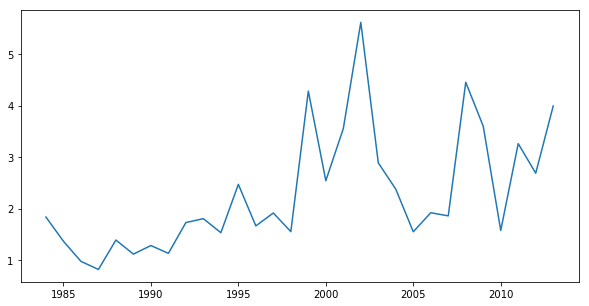

In [13]:
amape = AMAPE()
amapeScore = amape(df_predictions)

print("AMAPE 2013: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

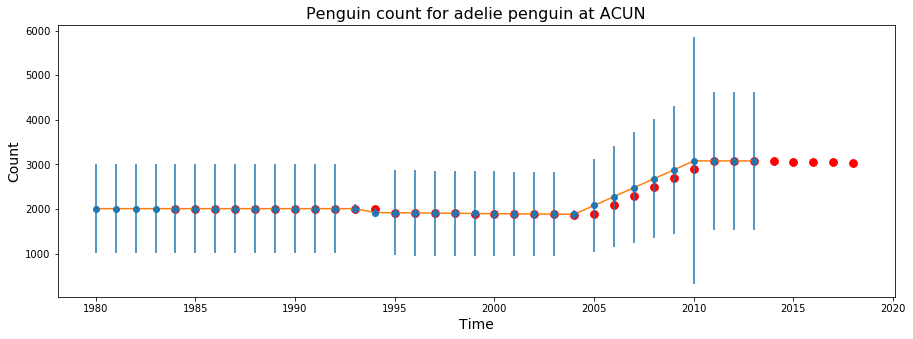

In [14]:
# let's have a look at how the model works   
vis = PenguinVisualisation(df_predictions)
vis.plot_penguins(('ACUN', 'adelie penguin'));

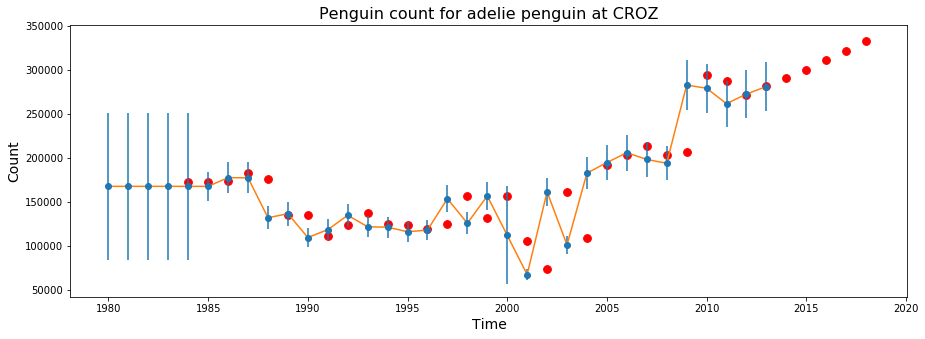

In [15]:
vis.plot_penguins(('CROZ', 'adelie penguin'));

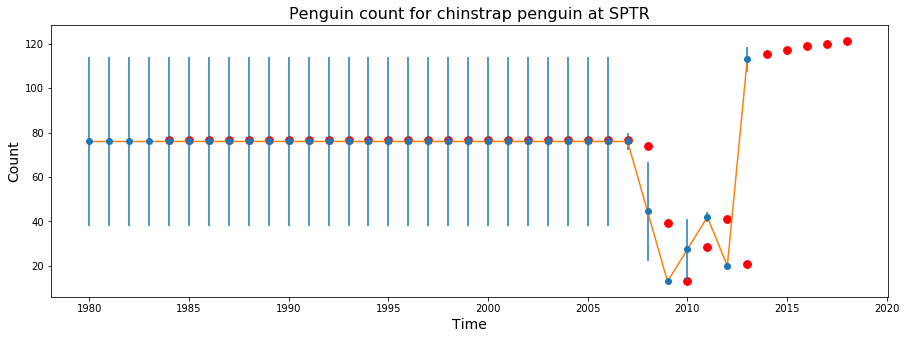

In [16]:
vis.plot_penguins(('SPTR', 'chinstrap penguin'));

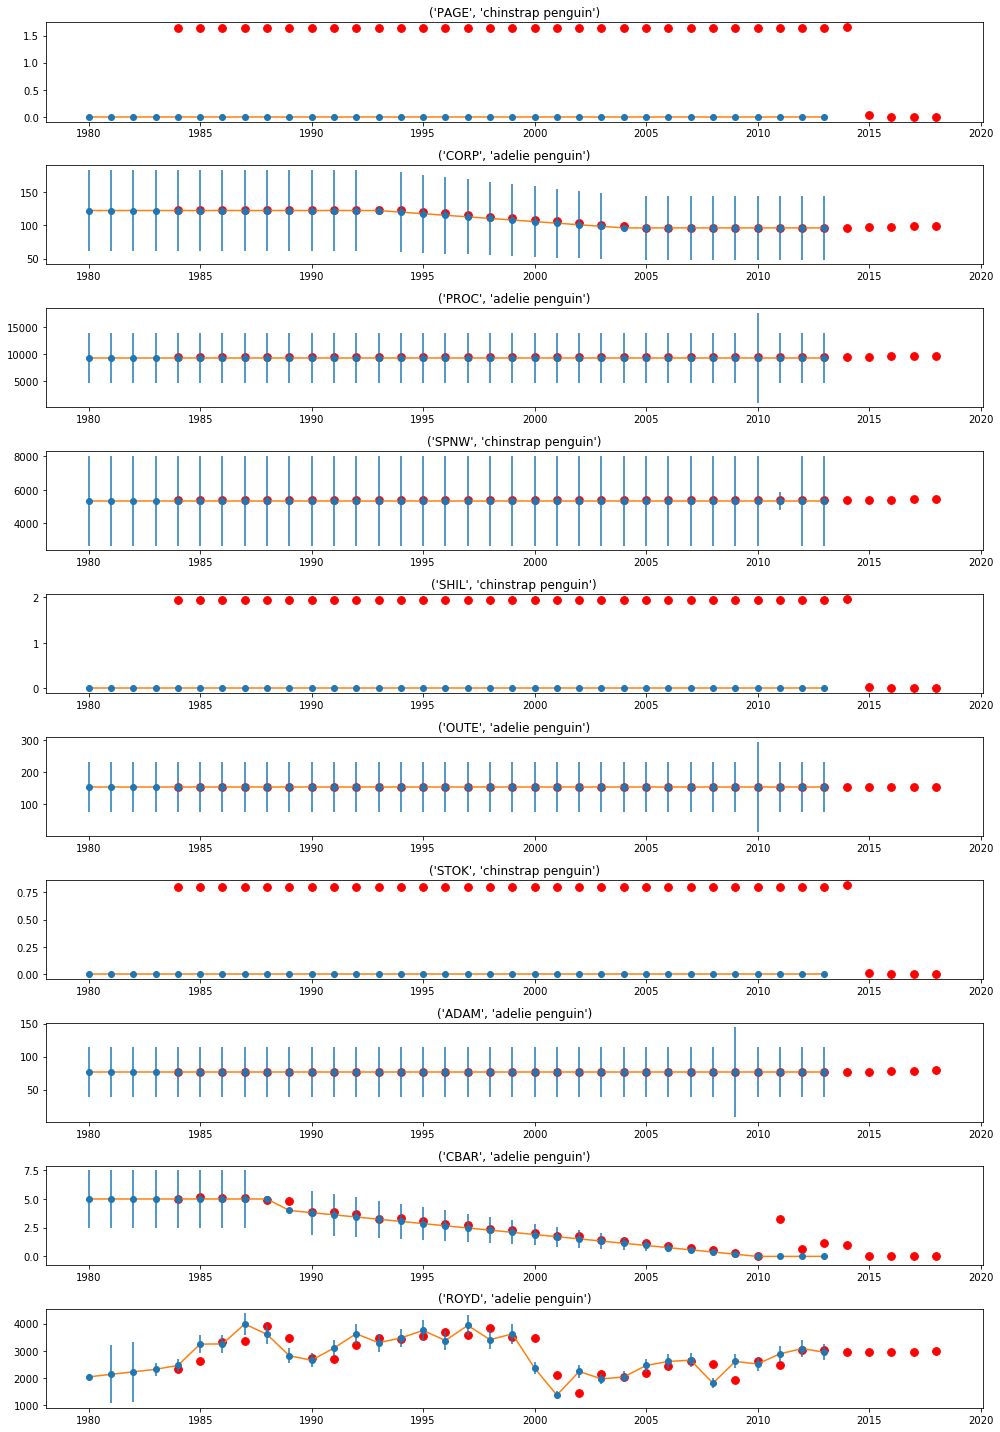

In [17]:
# Check some entries at random
vis.plot_random();

In [18]:
# Assemble the submission
#df_submissions = assemble_submission(df_predictions)
#df_submissions.head()